# Combined model

In this notebook we will combine the optimized version of the three models we've created. So, the predictions of our k-Nearest Neighbor, Decision tree and Neural Network will be combined to one new prediction. 

In [15]:
# Instal nbimporter to be able to import functions from other notebooks
!pip install nbimporter

In [16]:
from data_processing import prepare_data, split_data, one_hot_encode
import numpy as np
import pandas as pd
import nbimporter
from helper_functions import get_metrics

# Import functions for k-nearest neighbors
from k_Nearest_Neighbors import split_datatypes, train_and_predict
from oversampling import smote_loop

# Import functions for decision tree
from Decision_tree import resampled_forest

# Import functions for deep neural networks
from deep_neural_network import train_and_predict as train_dNN
from deep_neural_network import get_model

In [17]:
# Load the data normalized
data = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False, binary = False, normalize = True)

# Split the normalized data into training, testing and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, (0.6, 0.2, 0.2))

# Change the data to one-hot encoded data to be able to train the forest and deep neural network
train_hot = one_hot_encode(train_data)
test_hot = one_hot_encode(test_data)
val_hot = one_hot_encode(val_data)

### k-Nearest Neighbors
The k-Nearest Neighbors model with the best balanced accuracy was trained on only numeric data that was overfitted with a ratio of 0.6. 

In [18]:
# Split test data into numeric and binary data
test_num, test_bin = split_datatypes(test_hot)
val_num, val_bin = split_datatypes(val_hot)

# Get the oversampled data with a oversampling ratio of 0.6
data_list, labels_list, ratio_list = smote_loop(train_data, train_labels, 0.6, 0.7, 0.1)
train_num, train_bin = split_datatypes(data_list[0])

# Predictions using model trained on numerical, oversampled data and euclidean distance metric and 5 neighbors
predict_train_kNN, predict_val_kNN = train_and_predict(train_num, labels_list[0], val_num, 5, "distance", 
                                                          metric='euclidean')
predict_train_kNN, predict_test_kNN = train_and_predict(train_num, labels_list[0], test_num, 5, "distance", 
                                                           metric='euclidean')

print('The accuracy using only k-Nearest Neighbors: ')
get_metrics(test_labels, predict_test_kNN, verbose = True);

The accuracy using only k-Nearest Neighbors: 
accuracy: 83.5616 %
balanced accuracy: 67.6440 %
sensitivity: 0.5000
specificity: 0.8529 

confusion matrix: 
[[829 143]
 [ 25  25]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Resampled Forest
The optimal number of splits was around 17 most of the time.

In [19]:
# Create a tuple of the data that gets accepted by the forest function
data_DT_val = (train_hot, train_labels, val_hot, val_labels)
data_DT_test = (train_hot, train_labels, test_hot, test_labels)

# Train the forest on the training data and return a list with predicted labels fror training and testing data
predict_train_DT, predict_val_DT = resampled_forest(data_DT_val, 17)
predict_train_DT, predict_test_DT = resampled_forest(data_DT_test, 17)

print('The accuracy using only Resampled Forest: ')
get_metrics(test_labels, predict_test_DT, verbose = True);

The accuracy using only Resampled Forest: 
accuracy: 74.2661 %
balanced accuracy: 71.2942 %
sensitivity: 0.6800
specificity: 0.7459 

confusion matrix: 
[[725 247]
 [ 16  34]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Deep Neural Network

In [20]:
# Create a Deep Neural Network with two hidden layers 
model = get_model(train_hot, hidden_layers=2, nodes=[25, 15], dropout_rate=[0.3, 0.3])

# Get the predictions for the training and testing data using the Deep Neural Network
predict_train_dNN, predict_val_dNN, history = train_dNN(model, train_hot, train_labels, val_hot, val_labels, 
                                                         class_weight = 15, plot=False, batch_size=None, epochs=50, verbose=0)
predict_train_dNN, predict_test_dNN, history = train_dNN(model, train_hot, train_labels, test_hot, test_labels, 
                                                         class_weight = 15, plot=False, batch_size=None, epochs=50, verbose=0)

print('The accuracy using the deep Neural Netwerk: ')
get_metrics(test_labels, predict_test_dNN, verbose = True);

The accuracy using the deep Neural Netwerk: 
accuracy: 75.3425 %
balanced accuracy: 71.8601 %
sensitivity: 0.6800
specificity: 0.7572 

confusion matrix: 
[[736 236]
 [ 16  34]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



# Combining the models
The models can be combined in different ways. Considering we started with too few stroke predictions an OR function might be good, with the OR function only one models must return stroke as prediction for the combination of models to return stroke as well. We will try to combine all three models we've created, but we will also combine just the models with the highest predictions: resampled forest and the neural network. 

In [21]:
# Reshape the predictions of the deep Neural Network from matrices to arrays
predict_test_dNN = predict_test_dNN.reshape(1022, )
predict_val_dNN = predict_val_dNN.reshape(1022, )
predict_train_dNN = predict_train_dNN.reshape(3065,)

# Combine the predictions in a way that only one of the models has to return true for the combination to be true
predict_combined_val = (predict_val_kNN + predict_val_DT + predict_val_dNN) >= 1
predict_combined_test = (predict_test_kNN + predict_test_DT + predict_test_dNN) >= 1

# Combine the predictions so at least two models must predict a stroke for the combined model to predict stroke
predict_combined_val_2 = (predict_val_kNN + predict_val_DT + predict_val_dNN) >= 2
predict_combined_test_2 = (predict_test_kNN + predict_test_DT + predict_test_dNN) >= 2

print('The accuracy using the combined predictions on validation data: ')
get_metrics(val_labels, predict_combined_val, verbose = True);

print('The accuracy using the combined predictions on validation data based on majority vote: ')
get_metrics(val_labels, predict_combined_val_2, verbose = True);

The accuracy using the combined predictions on validation data: 
accuracy: 65.3620 %
balanced accuracy: 74.2016 %
sensitivity: 0.8400
specificity: 0.6440 

confusion matrix: 
[[626 346]
 [  8  42]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

The accuracy using the combined predictions on validation data based on majority vote: 
accuracy: 75.2446 %
balanced accuracy: 75.6029 %
sensitivity: 0.7600
specificity: 0.7521 

confusion matrix: 
[[731 241]
 [ 12  38]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [22]:
# Use the method of combining the predictions that leads to the highest balanced accuracy on the testing data
print('The accuracy using the combined predictions on test data: ')
get_metrics(test_labels, predict_combined_test, verbose = True);

The accuracy using the combined predictions on test data: 
accuracy: 68.9824 %
balanced accuracy: 74.2078 %
sensitivity: 0.8000
specificity: 0.6842 

confusion matrix: 
[[665 307]
 [ 10  40]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



Here we build a neural network and train it on the predictions of the models.

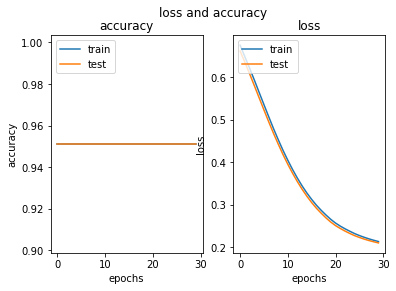

accuracy: 95.1076 %
balanced accuracy: 50.0000 %
sensitivity: 0.0000
specificity: 1.0000 

confusion matrix: 
[[972   0]
 [ 50   0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



(0.9510763209393346, 0.5)

In [26]:
# Create dataframes with the predictions from the models
combined_val = pd.DataFrame({'DT': predict_val_DT, 'NN': predict_val_dNN})
combined_test = pd.DataFrame({'DT': predict_test_DT, 'NN': predict_test_dNN})
combined_train = pd.DataFrame({'DT': predict_train_DT, 'NN': predict_train_dNN})

# Create a neural network
model_combined = get_model(combined_train, hidden_layers=1, nodes=[2], dropout_rate=[])

# Train the neural network on the combined predictions and return the predictions for the train and test data
predictions_train, predictions_test, history = train_dNN(model_combined, combined_val, val_labels, combined_test, test_labels,
                                                        class_weight = 1, plot=True, batch_size=None,
                                                        epochs=30, verbose=0)

get_metrics(test_labels, predictions_test, verbose = True)